In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
np.random.seed(2021)

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
train_df = pd.read_csv("/content/imputed_train_whole_file.csv")
test_df = pd.read_csv("/content/imputed_test_whole_file.csv")

In [ ]:
df = train_df.copy()
df = df.append(test_df)

In [ ]:
neg, pos = np.bincount(df["y_true"])

In [ ]:
total = neg + pos
print('Data Class count:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Data Class count:
    Total: 17917
    Positive: 2361 (13.18% of total)



In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [ ]:
train_labels = np.array(train_df.pop('y_true'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('y_true'))
test_labels = np.array(test_df.pop('y_true'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (11466,)
Validation labels shape: (2867,)
Test labels shape: (3584,)
Training features shape: (11466, 85)
Validation features shape: (2867, 85)
Test features shape: (3584, 85)


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 150
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1376      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# No bias
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6183


In [ ]:
# Set initial bias
initial_bias = np.log([pos/neg])
initial_bias

array([-1.88536116])

In [ ]:
model = make_model(output_bias=initial_bias)

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3861


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

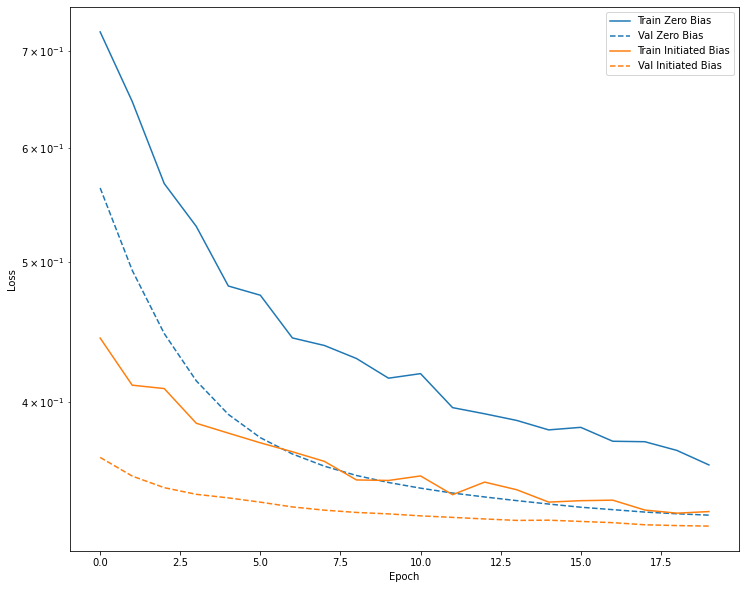

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Initiated Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/150
12/12 [==============================] - 3s 101ms/step - loss: 0.4446 - tp: 162.1538 - fp: 287.1538 - tn: 8249.0000 - fn: 1131.4615 - accuracy: 0.8574 - precision: 0.3741 - recall: 0.1255 - auc: 0.6635 - prc: 0.2446 - val_loss: 0.3644 - val_tp: 16.0000 - val_fp: 19.0000 - val_tn: 2462.0000 - val_fn: 370.0000 - val_accuracy: 0.8643 - val_precision: 0.4571 - val_recall: 0.0415 - val_auc: 0.7017 - val_prc: 0.2915
Epoch 2/150
12/12 [==============================] - 0s 10ms/step - loss: 0.4213 - tp: 125.2308 - fp: 242.8462 - tn: 5808.0000 - fn: 786.6923 - accuracy: 0.8515 - precision: 0.3297 - recall: 0.1335 - auc: 0.6330 - prc: 0.2222 - val_loss: 0.3546 - val_tp: 21.0000 - val_fp: 21.0000 - val_tn: 2460.0000 - val_fn: 365.0000 - val_accuracy: 0.8654 - val_precision: 0.5000 - val_recall: 0.0544 - val_auc: 0.7283 - val_prc: 0.3219
Epoch 3/150
12/12 [==============================] - 0s 11ms/step - loss: 0.4256 - tp: 118.8462 - fp: 210.9231 - tn: 5830.0769 - fn: 802.9231 - accura

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()

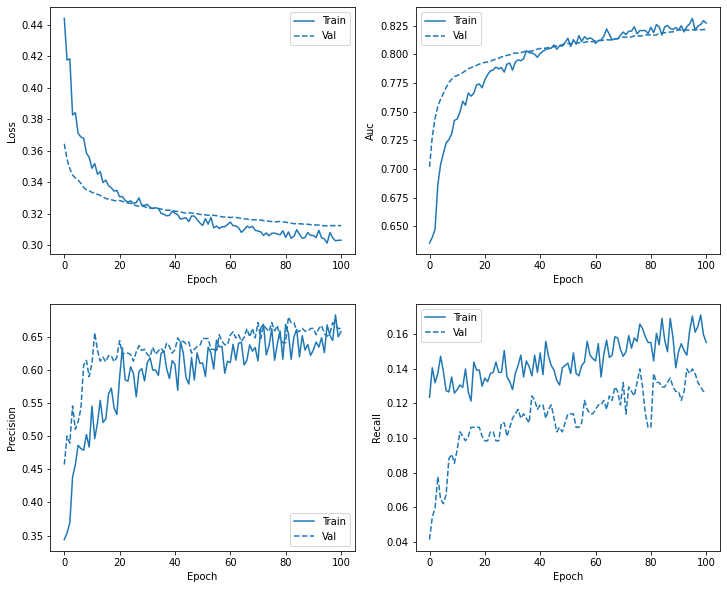

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix threshold:{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Survived more than 30 days (True Negatives): ', cm[0][0])
  print('(False Positives): ', cm[0][1])
  print('(False Negatives): ', cm[1][0])
  print('Died within 30 days (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.29537031054496765
tp :  61.0
fp :  38.0
tn :  3079.0
fn :  406.0
accuracy :  0.8761160969734192
precision :  0.6161616444587708
recall :  0.13062098622322083
auc :  0.8411048054695129
prc :  0.46126750111579895

Survived more than 30 days (True Negatives):  3079
(False Positives):  38
(False Negatives):  406
Died within 30 days (True Positives):  61
Total Fraudulent Transactions:  467


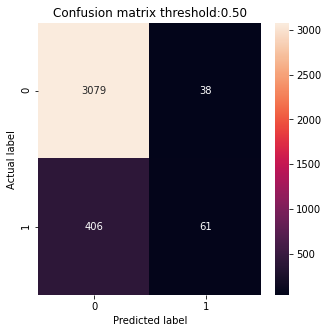

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-5, 105])
  plt.ylim([-5, 105])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

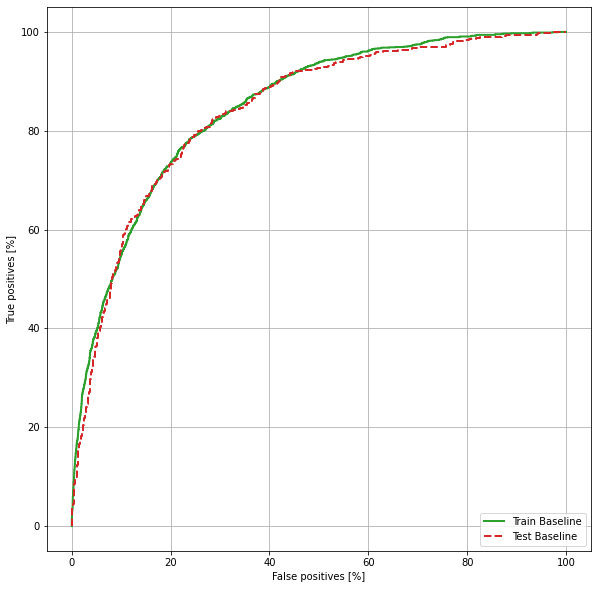

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[3], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

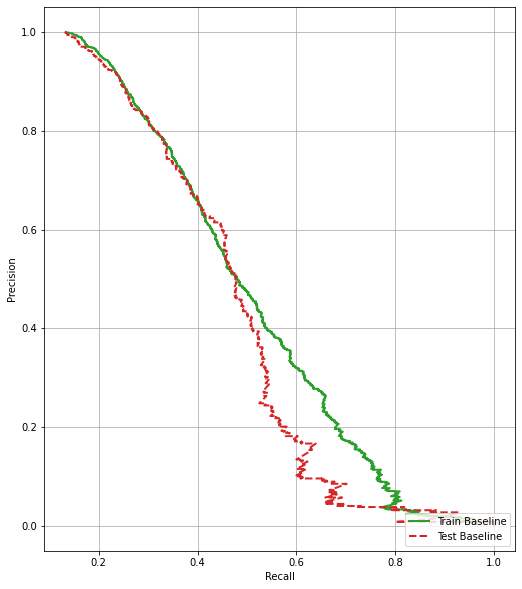

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[3], linestyle='--')
plt.legend(loc='lower right')

# Class Weights

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.58
Weight for class 1: 3.79


In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/150
12/12 [==============================] - 3s 97ms/step - loss: 1.0973 - tp: 196.0769 - fp: 366.9231 - tn: 8810.6923 - fn: 1173.0769 - accuracy: 0.8559 - precision: 0.3644 - recall: 0.1406 - auc: 0.6920 - prc: 0.2667 - val_loss: 0.3699 - val_tp: 49.0000 - val_fp: 59.0000 - val_tn: 2422.0000 - val_fn: 337.0000 - val_accuracy: 0.8619 - val_precision: 0.4537 - val_recall: 0.1269 - val_auc: 0.7065 - val_prc: 0.2955
Epoch 2/150
12/12 [==============================] - 0s 9ms/step - loss: 0.9884 - tp: 201.6923 - fp: 453.0000 - tn: 5589.8462 - fn: 718.2308 - accuracy: 0.8317 - precision: 0.3106 - recall: 0.2139 - auc: 0.6381 - prc: 0.2390 - val_loss: 0.3754 - val_tp: 100.0000 - val_fp: 124.0000 - val_tn: 2357.0000 - val_fn: 286.0000 - val_accuracy: 0.8570 - val_precision: 0.4464 - val_recall: 0.2591 - val_auc: 0.7362 - val_prc: 0.3279
Epoch 3/150
12/12 [==============================] - 0s 9ms/step - loss: 0.8868 - tp: 262.3077 - fp: 569.1538 - tn: 5482.0769 - fn: 649.2308 - accurac

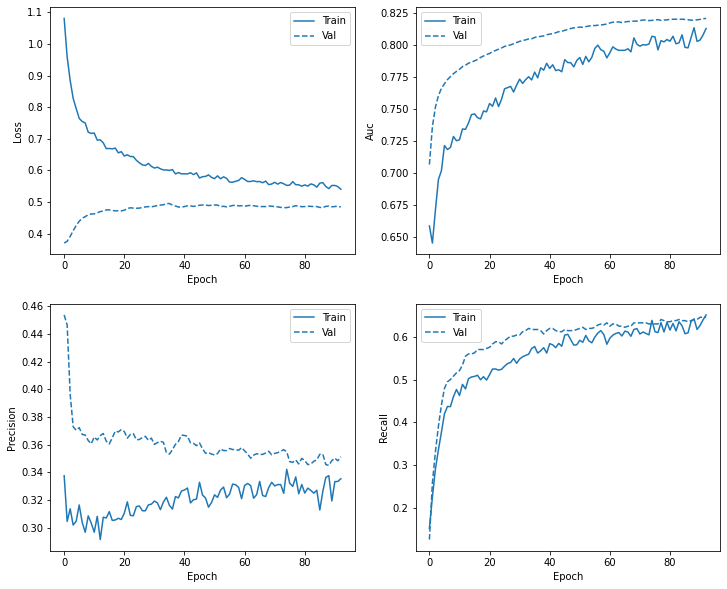

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.6431283950805664
tp :  327.0
fp :  567.0
tn :  2550.0
fn :  140.0
accuracy :  0.802734375
precision :  0.3657718002796173
recall :  0.700214147567749
auc :  0.8355735540390015
prc :  0.45394954085350037

Survived more than 30 days (True Negatives):  2550
(False Positives):  567
(False Negatives):  140
Died within 30 days (True Positives):  327
Total Fraudulent Transactions:  467


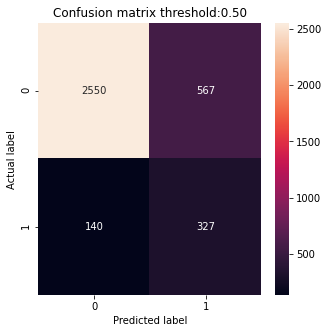

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

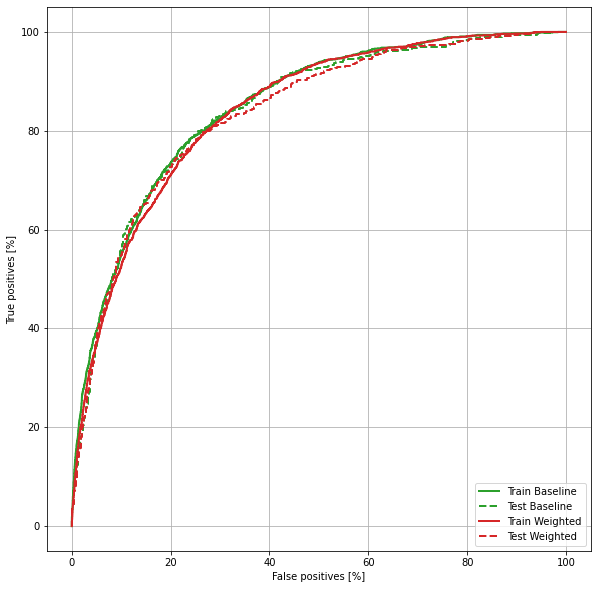

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[2], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[3])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[3], linestyle='--')


plt.legend(loc='lower right')

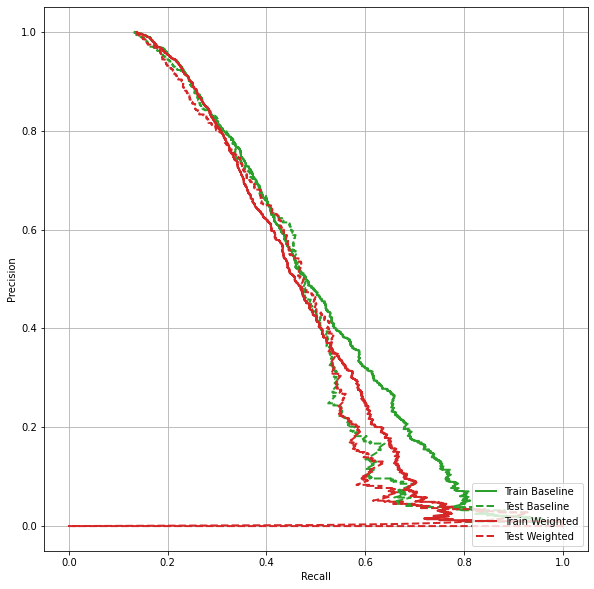

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[2], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[3])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[3], linestyle='--')


plt.legend(loc='lower right')

# Oversampling

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
# We have almost the same number of positive and negative this time
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5


In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

31.0

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/150
31/31 [==============================] - 3s 43ms/step - loss: 0.7695 - tp: 5022.4375 - fp: 3727.3125 - tn: 7818.2812 - fn: 3879.9688 - accuracy: 0.6380 - precision: 0.5562 - recall: 0.5625 - auc: 0.6723 - prc: 0.5909 - val_loss: 0.6341 - val_tp: 275.0000 - val_fp: 754.0000 - val_tn: 1727.0000 - val_fn: 111.0000 - val_accuracy: 0.6983 - val_precision: 0.2672 - val_recall: 0.7124 - val_auc: 0.7507 - val_prc: 0.3492
Epoch 2/150
31/31 [==============================] - 0s 11ms/step - loss: 0.6660 - tp: 5297.2500 - fp: 2748.4375 - tn: 5706.5000 - fn: 3111.8125 - accuracy: 0.6516 - precision: 0.6564 - recall: 0.6289 - auc: 0.7061 - prc: 0.6953 - val_loss: 0.5923 - val_tp: 272.0000 - val_fp: 676.0000 - val_tn: 1805.0000 - val_fn: 114.0000 - val_accuracy: 0.7245 - val_precision: 0.2869 - val_recall: 0.7047 - val_auc: 0.7714 - val_prc: 0.3712
Epoch 3/150
31/31 [==============================] - 0s 11ms/step - loss: 0.6253 - tp: 5445.4375 - fp: 2521.7812 - tn: 5949.4375 - fn: 2947.34

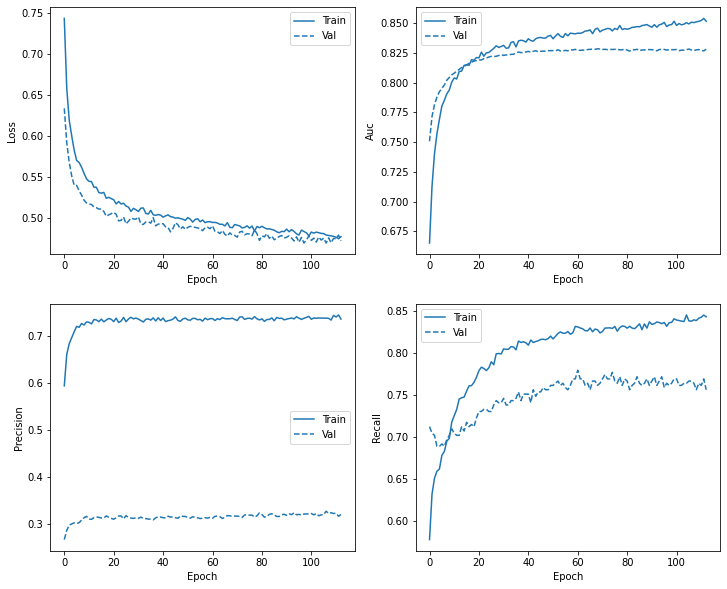

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.46630486845970154
tp :  367.0
fp :  786.0
tn :  2331.0
fn :  100.0
accuracy :  0.7527901530265808
precision :  0.3183000981807709
recall :  0.7858672142028809
auc :  0.8461105823516846
prc :  0.47078293561935425

Survived more than 30 days (True Negatives):  2331
(False Positives):  786
(False Negatives):  100
Died within 30 days (True Positives):  367
Total Fraudulent Transactions:  467


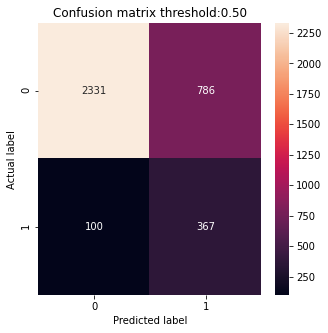

In [ ]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

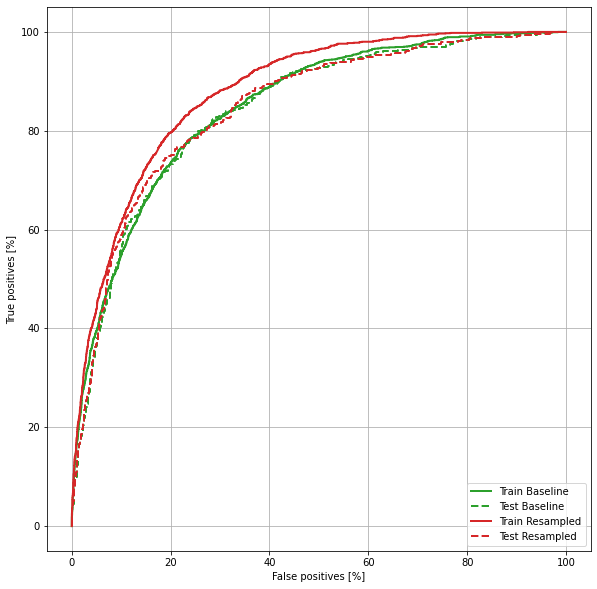

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[2], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[3])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[3], linestyle='--')
plt.legend(loc='lower right')

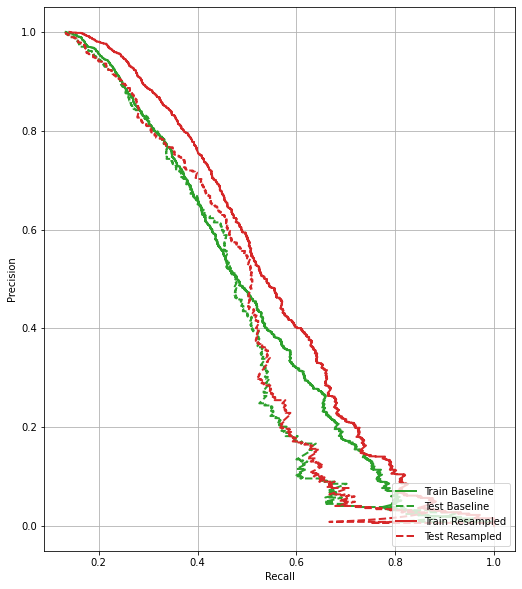

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[2])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[2], linestyle='--')


plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[3])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[3], linestyle='--')
plt.legend(loc='lower right')

# Save models

In [ ]:
keras.models.save_model(weighted_model, "./weighted_model")

INFO:tensorflow:Assets written to: ./weighted_model/assets


In [ ]:
keras.models.save_model(resampled_model, "./resampled_model")

INFO:tensorflow:Assets written to: ./resampled_model/assets


In [ ]:
!zip -r weighted_model.zip weighted_model

updating: weighted_model/ (stored 0%)
  adding: weighted_model/assets/ (stored 0%)
  adding: weighted_model/variables/ (stored 0%)
  adding: weighted_model/variables/variables.data-00000-of-00001 (deflated 35%)
  adding: weighted_model/variables/variables.index (deflated 67%)
  adding: weighted_model/saved_model.pb (deflated 88%)


In [ ]:
!zip -r resampled_model.zip resampled_model

updating: resampled_model/ (stored 0%)
  adding: resampled_model/assets/ (stored 0%)
  adding: resampled_model/variables/ (stored 0%)
  adding: resampled_model/variables/variables.data-00000-of-00001 (deflated 35%)
  adding: resampled_model/variables/variables.index (deflated 67%)
  adding: resampled_model/saved_model.pb (deflated 88%)
